# Prediction with classifier

In [9]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import pickle
#import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xgboost
from model.models import TradeModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.grid_search import GridSearchCV
from pandas_ml import ConfusionMatrix
from service.files_service import get_files

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Given a df with trade features(ATR,Keltner,Donchian), forecast if the next period will have a High with a pip higher than 10.

In [12]:
all_files = get_files(folder = 'data/all_data/resampled_D/',extension='.csv',as_dict=True,filter_on='_D_')

In [13]:
def make_prediction(tm,date):
    df = tm.df.copy()
   
    
    predictors =df.columns.tolist()
    df['target']=((df.High-df.High.shift(-1))*10000>=10)*1
    
    clf = xgboost.XGBClassifier()
    
    df_train = df[df.index<date]
    df_test = df[df.index==date]
 
    
      
    X_train,y_train = df_train[predictors].values,df_train.target.values
    X_test, y_test  = df_test[predictors].values,df_test.target.values
    
    clf = cv_optimize(clf,{},X_train,y_train)
    
    df_test['prediction'] = clf.predict(X_test)
    
    score =  clf.score(X_test,y_test)

    
    return y_test[0],df_test['prediction'][0],clf

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=-1)
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_    

In [15]:
def compute_confusion_matrix(tm):
    real_result = []
    predicted_result=[]
    
    test_sample=100
    for dt in (tm.df.tail(test_sample).index.values):
        real,predicted,_ = make_prediction(tm, dt)
        break
        
        real_result.append(real)
        predicted_result.append(predicted)
        
    return ConfusionMatrix(real_result, predicted_result)

In [16]:
confusion_matrixes = {}
for k,v in all_files.iteritems():
    tm =TradeModel('data/all_data/resampled_D/'+v, name=k, datetime_col='ds')
    confusion_matrixes[k]=compute_confusion_matrix(tm)

/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AssertionError: Binary confusion matrix must have len=2 but len=0 because y_true.unique()=[] y_pred.unique()=[]

In [ ]:
confusion_matrixes['resampled_D_BRENTCMDUSD']

In [ ]:
pickle.dump(confusion_matrixes, open('data/confusion_matrix2.p', "wb"))

In [ ]:
cmo = pickle.load(open('data/confusion_matrix2.p', "rb"))

In [ ]:
df_CM_all = pd.DataFrame()
for k,v in cmo.iteritems():
    print v.stats_class.loc['PPV: Pos Pred Value (Precision)'][1]
    
    df_cm = cmo[k].to_dataframe()
    df_cm.index=[k +'_Actual_Negative',k +'_Actual_Positive']
    df_cm.columns=['Predicted_negative','Predicted_Positive']
    df_CM_all = pd.concat([df_CM_all,df_cm],axis=0)


## Results of prediction "is pip on day+1 on **High** > 10 ?" on 8 differents currencies

In [17]:
from datetime import timedelta
datetime(2016,12,8) - timedelta(100)

datetime.datetime(2016, 8, 30, 0, 0)

- each exchange rate dataset ranges from 2010/2011 until dec.8th 2016.
- we use the daily period.
- for the last 100 days of each dataset (ie 30th Aug 2016 until 8th dec 2016) : we compute the prediction that determine whether on day+1 the High value will be higher >10 pips.

The table below is a summary of the prediction vs the actual result per exchange-rate :

In [18]:
def testo(row):
    if  ('Positive' in row.name):
        return 1
    elif ('Negative' in row.name):
        return -1
    else :
        return 0

In [19]:
df_CM_all['win_lose']=df_CM_all.apply(testo,axis=1)


NameError: name 'df_CM_all' is not defined

In [20]:
df_CM_all['gain_loss']=df_CM_all.win_lose * (100) * df_CM_all.Predicted_Positive
df_CM_all['invested']=df_CM_all.Predicted_Positive * (100)

NameError: name 'df_CM_all' is not defined

In [21]:
df_CM_all

NameError: name 'df_CM_all' is not defined

In [22]:
print df_CM_all.gain_loss.sum()
print df_CM_all.invested.sum()
print df_CM_all.gain_loss.sum()*1.0/df_CM_all.invested.sum()*100.0

NameError: name 'df_CM_all' is not defined

### Plot ROC Curve
See lab6-classification-redux.ipynb CS109-2015

In [23]:
-

### Quick dirty method to test the ROC plotting

In [24]:
def test_ROC(date):
    tm =TradeModel('data/all_data/resampled_D/resampled_H_USDCAD_UTC_1 Min_Bid_2010.01.02_2016.12.08.csv',\
                   name='test', datetime_col='ds')
    df=tm.df.copy()
    
    predictors =df.columns.tolist()
    
    df['target']=((df.High-df.High.shift(-1))*10000>=10)*1
    
    clf = xgboost.XGBClassifier()
    
    df_train = df[df.index<date]
    df_test = df[df.index>=date]
 
    print df_test.shape
      
    X_train,y_train = df_train[predictors].values,df_train.target.values
    X_test, y_test  = df_test[predictors].values,df_test.target.values
    
    clf.fit(X_train,y_train)
    
    prediction = clf.predict_proba(X_test)
    
    return X_test, y_test,clf
    

In [25]:
X_test, y_test,clf = test_ROC(datetime(2016,12,8) - timedelta(100))

(2424, 37)


In [26]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

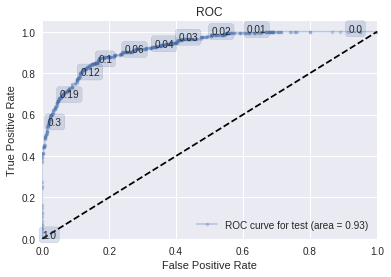

In [27]:
ax = make_roc('test',clf,y_test,X_test)